# Data Presentation

## Purpose

The goal of this notebook is to observe the data containing the protocol csv and cleaning up
into a more proper data_csv for further analysis

## Data 
Agurim Data was used for this notebook.

Agurim is a network traffic monitor website providing the volume of packet over time.  We can get information on the volume based on their IP adress or their protocol

The data is taken from the transit link of the WIDE network (AS2500) in Japan since February 2013. IP addresses appearing in the dataset are anonymized using a prefix-preserving method. More information about the dataset is available from the MAWI working group traffic archive.

for more information, please consult:  
- <http://mawi.wide.ad.jp/~agurim/about.html>
- <http://mawi.wide.ad.jp/~agurim/index.html>

# Base setup
small setup used for the future data visualisation

In [6]:

from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import datetime
% matplotlib inline




# Getting data

In [7]:
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

raw_df = pd.read_csv("../data/base_proto_traffic.csv", 
                 parse_dates=True, date_parser=dateparse, 
                 index_col="timestamp",
                 usecols=["TOTAL","timestamp"])

len(raw_df)

292264

# Transforming data

In [19]:
# transform data into a time series
def iqr_outlier_discard(ts, lower, upper,thresh_bottom=0):
    # note :: begin values may be loosing
    low_quant, up_quant = ts.quantile(lower), ts.quantile(upper)
    iqr = (up_quant - low_quant) * 1.5
    upper_tresh = up_quant + iqr
    lower_tresh = low_quant - iqr
    ts[ts > upper_tresh] = np.nan
    ts[ts <= lower_tresh] = np.nan
    return ts

#transform in a time series
raw_ts = raw_df.T.squeeze()

#replace extreme value by interpolation
ts = iqr_outlier_discard(raw_ts.copy(),0.075,0.925)
ts = ts.interpolate()

# remove offsets
ts.index = ts.index.tz_localize("GMT").tz_convert("Asia/Tokyo")
ts = ts.astype(np.int64)
ts = ts.rename("total_traffic")


# Observations
## outliers
some outlier was found in filtered during the data transformation

1. two points that are ~100000000 times bigger than the normal traffic(they are clearly erros)
2. two points that are ~5 times bigger than the average traffic during this period 



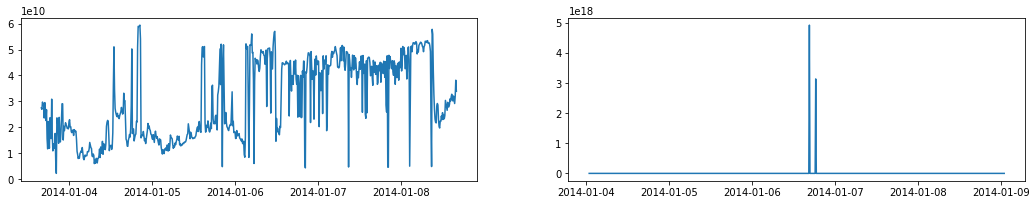

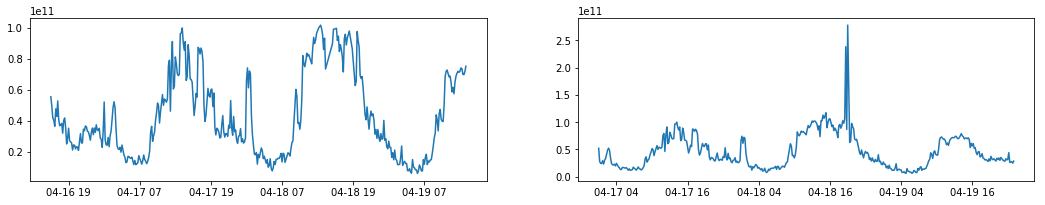

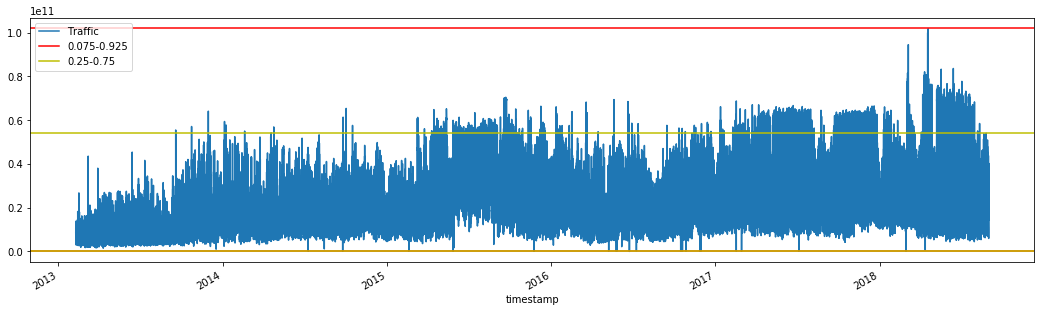

In [20]:
def plot_comparison(begin,end):
    fig, axs = plt.subplots(1, 2, figsize=(18, 3))
    axs[0].plot(ts[begin:end])
    axs[1].plot(raw_ts[begin:end])
    
    
def plot_iqr_threshold(color,lower,upper):
    low_quant,up_quant = ts.quantile(lower),ts.quantile(upper)
    iqr = (up_quant - low_quant) * 1.5
    upper_tresh =up_quant + iqr 
    lower_tresh =low_quant - iqr  
    lower_tresh = lower_tresh if lower_tresh > 0 else 0 

    plt.axhline(upper_tresh,color=color, label=f"{lower}-{upper}")
    plt.axhline(lower_tresh ,color=color)
    
    
plot_comparison("2014-01-04 01:00:00","2014-01-09 01:00:00")
plot_comparison("2018-04-17 01:00:00","2018-04-19 23:00:00")


plt.figure(figsize=(18,5))
ts.plot(label="Traffic")
plot_iqr_threshold("r",0.075,0.925)
plot_iqr_threshold("y",0.25,0.75)
plt.legend(loc="upper left")



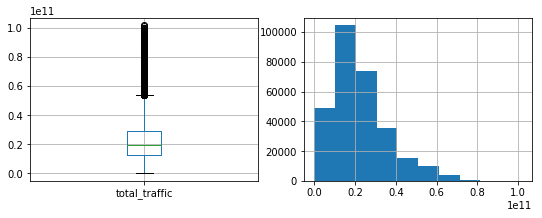

In [5]:
fig,axes = plt.subplots(1,2,figsize=(9,3))
pd.DataFrame(ts).boxplot(ax=axes[0])
ts.hist(ax=axes[1])


## time difference
the data use the global UNIX time, the data was not in the GMT+9 timezone

by taking a short interval we can see that the traffic has a seasonal pattern everyday.
indeed WIDE traffic has a peak moment during the day and then going down 

note :: the data are probably not placed in the right timezone


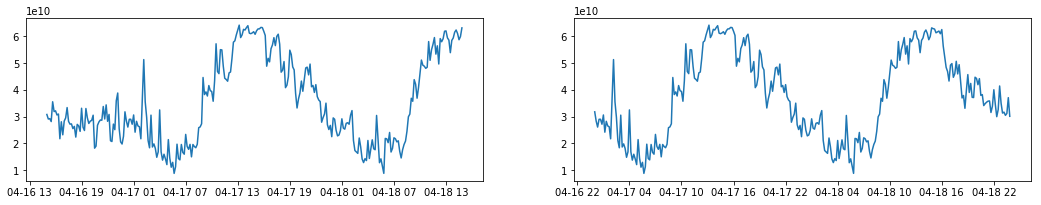

In [21]:
plot_comparison("2017-04-17 00:00:00","2017-04-18 23:50:00")


## Seasonality

by quickly analysing the seasonality we can see that the traffic repeat itself every 144x10 minutes, which is every day

daily


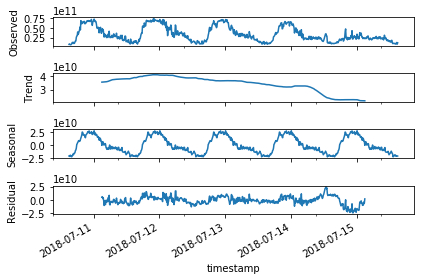

weekly


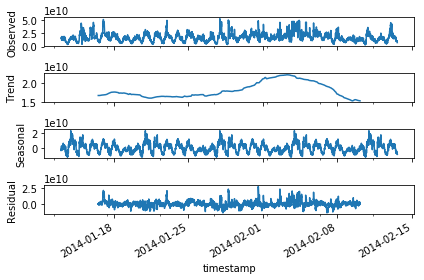

weekly


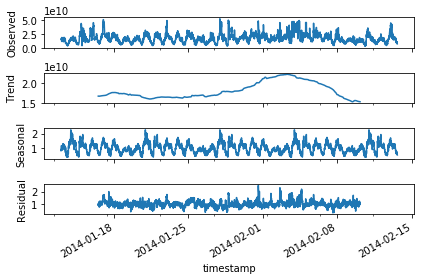

monthly


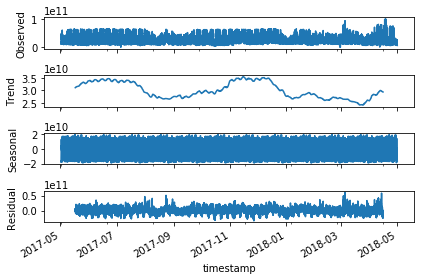

yearly


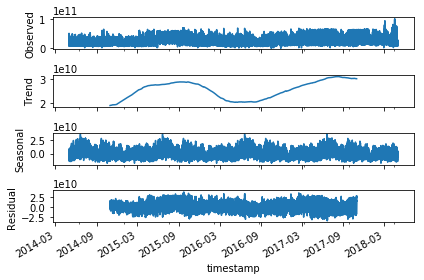

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_seasonality(ts,begin,end,name,freq,model='additive' ):
    print(name)
    result = seasonal_decompose(ts[begin:end], model=model,freq=freq)
    result.plot()
    plt.show()

plot_seasonality(ts,"2018-07-10 15:00:00","2018-07-15 15:00:00","daily",144)
plot_seasonality(ts,"2014-01-13 01:00:00","2014-02-13 15:00:00","weekly",144*7)
plot_seasonality(ts,"2014-01-13 01:00:00","2014-02-13 15:00:00","weekly-multiplicative",144*7,"multiplicative")
plot_seasonality(ts,"2017-05-01 15:00:00","2018-05-01 15:00:00","monthly",144*31)
plot_seasonality(ts,"2014-05-01 15:00:00","2018-05-01 15:00:00","yearly",144*365)
 

# Saving result

In [8]:
ts_towrite = ts.copy()
ts_towrite.index = ts.index.strftime("%Y-%m-%d %H:%M:%S")
ts_towrite.to_csv("../data/clean_proto_traffic.csv", header=True,index=True,index_label="timestamp")